# Mammogram Analysis Challenge

A mammogram is an X-ray of the breast used primarily by radiologists to detect signs of breast cancer like abnormal masses and calcifications (signs of a possible tumor). Sometimes these abnormalities are obvious, sometimes they are not. In younger women especially, masses and calcifications can be difficult for radiologists to detect in a mammogram due to dense surrounding tissue. This makes mammograms a great candidate for machine learning analysis. A program that can detect abnormalities with high accuracy could be used to catch radiologists' mistakes and potentially save lives (in fact, it already is—https://giving.massgeneral.org/machine-learning-breast-cancer-screening)


  <h3><center>Mammogram Image</center></h3>

<center><img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/mammogram_image.png" width=400></center>


For this challenge you will classify mammogram segments into two classes (positive for an abnormality and negative). You may also attempt to use the "multiclass labels" to classify the mammograms into five classes (negative, positive benign calcification, positive malignant calcification, positive benign mass, and positive malignant mass). We recommend you begin with the binary labels, but try both if you have time!

Below we provide you with code to visualize the dataset as well as a simple but functional model that does a relatively poor job at this classification problem. It's up to you to build a classifier that does better! Your models will be evaluated based on confusion matrix , Area under the ROC Curve, and Creativity.

Before you run any code make sure you turn GPU support on! (Edit > Notebook Settings > Hardware Accelerator).

## Imports

In [ ]:
### Run this cell to import the packages you will need to unpack the dataset
# File manipulation and IO (input/output)
import os
import pickle
import zipfile
from google.colab import files

# Import numerical and dataframe handling
import numpy as np
import scipy
import pandas as pd

# Data preprocessing
from PIL import Image
from sklearn.utils import shuffle

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib


In [ ]:
# Set plotting preferences
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

## Download the images and labels from our GitHub data repository

This dataset is from the publicly available Digital Database for Screening Mammography (DDSM) and the Curated Breast Imaging Subset of DDSM (CBIS-DDSM).

The binary labels are 0 (negative for an abnormality) and 1 (positive for an abnormality). The multiclass labels are:
* 0 = Negative
* 1 = Benign Calcification
* 2 = Benign Mass
* 3 = Malignant Calcification
* 4 = Malignant Mass

In the following cell, we download the images and labels from our GitHub data repository.

In [ ]:
# Set the path to the Week 3 challenge data on GitHub
github_data_path = 'https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/ChallengeProjects/Week3/'

# Download 3 zip files from github containing training, validation, and test images
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Test.zip'))
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Train.zip'))
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Val.zip'))

# Download the binary and multiclass labels for the 
os.system('wget ' + os.path.join(github_data_path,'train_binary_labels.csv'))
os.system('wget ' + os.path.join(github_data_path,'train_multiclass_labels.csv'))
os.system('wget ' + os.path.join(github_data_path,'val_binary_labels.csv'))
os.system('wget ' + os.path.join(github_data_path,'val_multiclass_labels.csv'))

0

## Loading the data into memory

Run the cell below to get all the data for this challenge. After running the cell, the following data will be loaded into the following variables:

* **train_binary_labels_df**: 2 column pandas df where each row contains a label (0 or 1) and the unique ID of the image the label corresponds to. 5500 samples/rows.
* **train_multiclass_labels_df**: 2 column pandas df where the rows contains a label (0, 1, 2, 3, 4) and the unique ID of the image the label corresponds to. 5500 samples/rows.
* **train_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 5500 samples/rows. 
* **train_images**: A np array (5500, 299,299) containing all training images (may be easier to deal with than the df)
* **test_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 1500 samples/rows.
* **test_images**: A np array (1500, 299,299) containing all training images (may be easier to deal with than the df)


DO NOT USE THE TEST IMAGES IN MODEL DEVELOPMENT AT ALL. ALSO, DO NOT SHUFFLE THE TEST IMAGES. These images will be used to evaluate your model and should only be run through the classifier ONCE at the time of submission. You will not have access to the test image labels.

Explore the variables listed above! 


### Unzip the Image Files

The following cell unzips the image files and prepares them to be loaded into memory.

In [ ]:
### Unzip the image data and populate dataframe objects ###
# Unzip all files to respective folders in current directory
zip_ref = zipfile.ZipFile('Mamm_Images_Train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Val.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Test.zip', 'r')
zip_ref.extractall()
zip_ref.close()  


### Store Images and Labels in Numpy Arrays and Dataframes

The following cell will load the images and labels into a pair of numpy ndarray and pandas dataframe objects.

In [ ]:
# Use pd.read_csv to open csv file contents to pandas dataframes
train_binary_labels_df = pd.read_csv('train_binary_labels.csv', header=None)
train_multiclass_labels_df = pd.read_csv('train_multiclass_labels.csv', header=None)
val_binary_labels_df = pd.read_csv('val_binary_labels.csv', header=None)
val_multiclass_labels_df = pd.read_csv('val_multiclass_labels.csv', header=None)

# Concatenate train/validation labels into one set
#(you may decide to separate later for your own train/val/mocktest split)
train_binary_labels_df = pd.concat([train_binary_labels_df, val_binary_labels_df], axis=0, ignore_index = True)
train_multiclass_labels_df = pd.concat([train_multiclass_labels_df, val_multiclass_labels_df], axis=0, ignore_index = True)

# Add columns to train_binary_labels_df dataframe that contains unique
# (original) indices of train data
unique_indices_df = pd.DataFrame(list(range(5500)))
train_binary_labels_df = pd.concat([train_binary_labels_df, unique_indices_df], axis=1)
train_binary_labels_df.columns = ['Label', 'Unique_Index']
train_multiclass_labels_df = pd.concat([train_multiclass_labels_df, unique_indices_df], axis=1)
train_multiclass_labels_df.columns = ['Label', 'Unique_Index']

# Load images from file and save to both
# 1) dataframe objects
# 2) numpy arrays of shape (num_examples, num_pixels_wide, num_pixels_high)

# Read in train images (from both train and val directories) to ndarray
train_images = np.zeros((5500,299,299), dtype=np.uint8)
for ind in range(5000):
  im = plt.imread('Mamm_Images_Train/image' + str(ind) + '.jpg')
  train_images[ind, :, :] = im
  
for ind in range(500):
  im = plt.imread('Mamm_Images_Val/image' + str(ind) + '.jpg')
  train_images[ind + 5000, :, :] = im

# Read in test images to ndarray
test_images = np.zeros((1500,299,299), dtype=np.uint8)
for ind in range(1500):
  im = plt.imread('Mamm_Images_Test/image' + str(ind) + '.jpg')
  test_images[ind, :, :] = im

# Make dataframes that contain the same information as the ndarrays
# The N-th row contains a 299x299 ndarray, and a unique index for that image
train_images_df = pd.DataFrame([[train_images[i,:,:] for i in range(train_images.shape[0])]])
train_images_df = train_images_df.transpose()
unique_indices_df = pd.DataFrame(list(range(5500)), dtype = np.int)
train_images_df = pd.concat([train_images_df, unique_indices_df], axis = 1)
train_images_df.columns = ['Images', 'Unique_Index']

test_images_df = pd.DataFrame([[test_images[i,:,:] for i in range(test_images.shape[0])]])
test_images_df = test_images_df.transpose()
unique_indices_df = pd.DataFrame(list(range(5500, 7000)), dtype = np.int)
test_images_df = pd.concat([test_images_df, unique_indices_df], axis = 1)
test_images_df.columns = ['Images', 'Unique_Index']

#Print out some information about populated variables
print(f'train_images.shape: {train_images.shape}\n')

print(f'test_images.shape: {test_images.shape}\n')

print('train_images_df.head():')
print(train_images_df.head())
print('\n')

print('test_images_df.head():')
print(test_images_df.head())
print('\n')

print('10 random rows of train_binary_labels_df:')
print(train_binary_labels_df.loc[np.random.randint(0,train_binary_labels_df.shape[0], size = (10,))])
print('\n')

print('10 random rows of train_multiclass_labels_df:')
print(train_multiclass_labels_df.loc[np.random.randint(0,train_multiclass_labels_df.shape[0], size = (10,))])
print('\n')


train_images.shape: (5500, 299, 299)

test_images.shape: (1500, 299, 299)

train_images_df.head():
                                              Images  Unique_Index
0  [[83, 82, 82, 82, 83, 85, 87, 88, 88, 88, 89, ...             0
1  [[121, 123, 126, 128, 128, 127, 125, 123, 120,...             1
2  [[151, 151, 151, 150, 150, 150, 149, 149, 154,...             2
3  [[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, ...             3
4  [[78, 78, 77, 77, 77, 78, 79, 79, 77, 78, 79, ...             4


test_images_df.head():
                                              Images  Unique_Index
0  [[107, 107, 108, 109, 109, 109, 108, 108, 107,...          5500
1  [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...          5501
2  [[18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, ...          5502
3  [[106, 107, 110, 112, 114, 115, 116, 116, 118,...          5503
4  [[170, 171, 171, 170, 169, 168, 167, 166, 164,...          5504


10 random rows of train_binary_labels_df:
      Label  Unique_Index
41

## Data Visualization

Run the cell below this one to see what the images you are working with look like. They are 299x299 pixel greyscale images of sections of mammograms. Generally, masses and calcifications show up as blobs of various size, shape, and brightness. As mentioned already, dense tissue shows up brighter on mammograms and it can be dificult to spot an abnormality in mammograms with denser tissue. Each image is labeled with its binary and multiclass labels. Notice that some images are not tissue at all but instead are segments of the mammogram labels (image 10 for example). Further data preprocessing or a robust classifier should successfully deal with these images. Rerun this cell to look at other images in the training dataset.


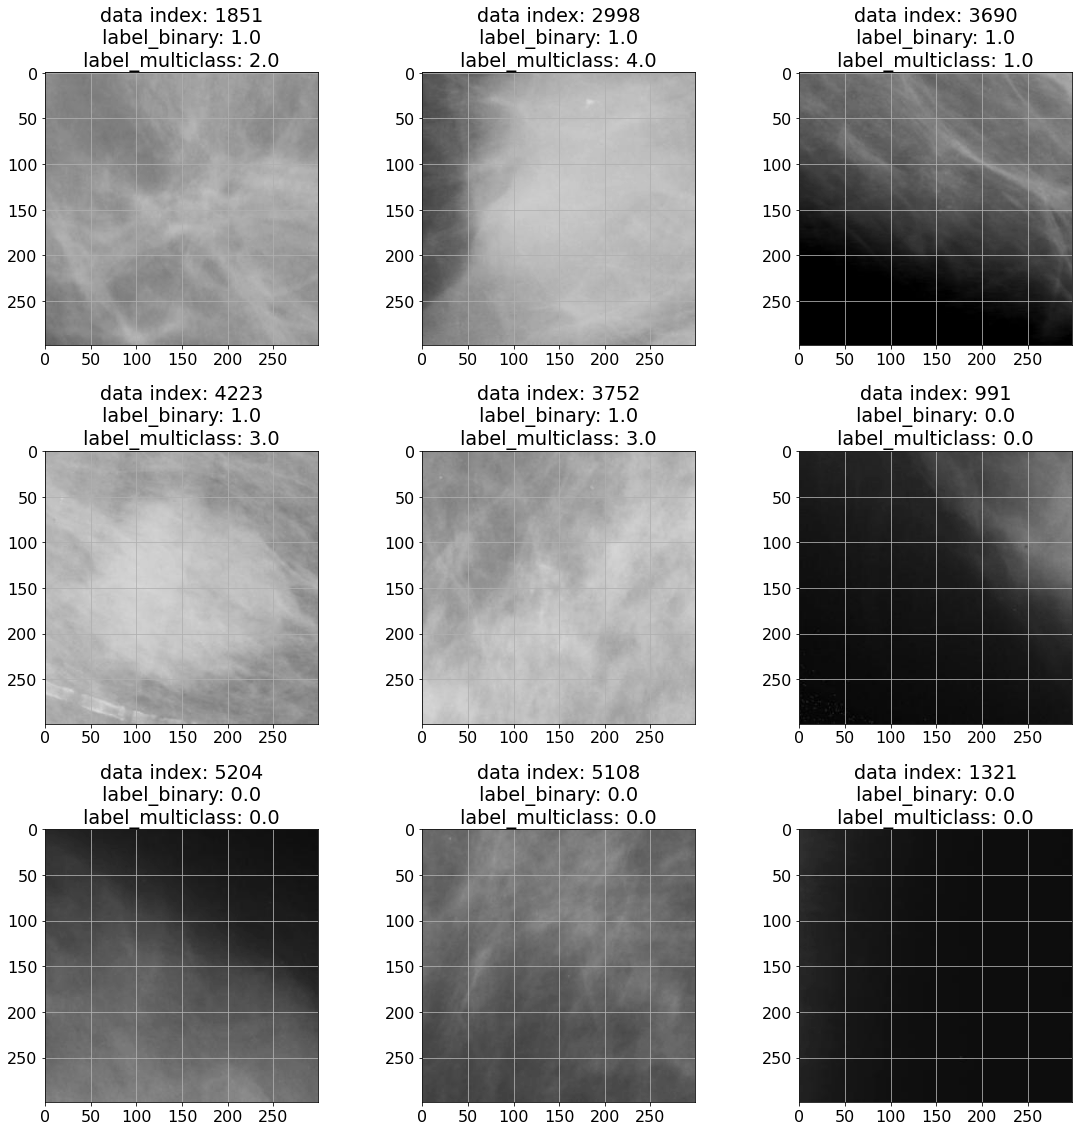

In [ ]:
### Visualize Images in Training Set

fig = plt.figure(figsize = (16,16))

for i in range(9): # change these numbers to explore the training dataset further
  imgInd = np.random.randint(0, len(train_images_df))
  ax = plt.gcf().add_subplot(3, 3, i+1)
  ax.imshow(train_images[imgInd], cmap='gray', vmin=0, vmax=255)
  ax.set_title("data index: " + str(imgInd) + "\nlabel_binary: " +
            str(train_binary_labels_df.iloc[imgInd,0]) +
            '\nlabel_multiclass: ' + str(train_multiclass_labels_df.iloc[imgInd,0]))
  
  #set major tick marks every 50 pixels
  ax.xaxis.set_major_locator(MultipleLocator(50))
  ax.yaxis.set_major_locator(MultipleLocator(50))

  #turn on grid lines
  ax.grid(True)

fig.tight_layout()


# Example binary CNN classifier

In [ ]:
### Create one-hot labels
train_binary_labels = train_binary_labels_df["Label"]

#convert labels to onehot, ensure type is float32
train_binary_labels = tf.keras.utils.to_categorical(train_binary_labels, 2).astype(np.float32)

In [ ]:
### Shuffle and partition labeled data

train_images_shuffled, train_binary_labels_shuffled = shuffle(train_images, train_binary_labels, random_state = 25, stratify = train_multiclass_labels_df["Label"])

#--Partition into train/val/mock_test--

#Note that in a 2D convolution, we need another dimension on all 
#train/val/mocktest data. This dimension corresponds to "number of channels"
#(an RGB image would have 3 channels, for example). Our images only have one 
#channel, but the 2D convolution layers still expect the last data dimension to 
#correspond to channel. (Without this added channel, error messages would result
#saying the expected number of dimensions into the 2D convolution layer is 4,
#and not 3. Feel free to try for yourself.)


val_size = 1000
mocktest_size = 500

mocktest_data = train_images_shuffled[0:mocktest_size, :, :, np.newaxis]
mocktest_binary_labels = train_binary_labels_shuffled[0:mocktest_size, :]

val_data = train_images_shuffled[mocktest_size:mocktest_size+val_size, :, :, np.newaxis]
val_binary_labels = train_binary_labels_shuffled[mocktest_size:mocktest_size+val_size, :]

partial_train_data = train_images_shuffled[mocktest_size+val_size:,:,:, np.newaxis]
tr_binary_labels = train_binary_labels_shuffled[mocktest_size+val_size:,:]

# Add three channels to training data to line up with tensorflow expectations
partial_train_data = np.concatenate([partial_train_data]*3, axis=3)
val_data = np.concatenate([val_data]*3, axis=3)
mocktest_data = np.concatenate([mocktest_data]*3, axis=3)
test_images = np.concatenate([test_images[:,:,:,np.newaxis]]*3, axis=3)

In [ ]:
# Clear session to enable reruns
tf.keras.backend.clear_session()

# Scrape a basic, prebuilt model from tenserflow applications library
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(299, 299, 3))

# Freeze the entire base model
base_model.trainable = False

# Flatten the data
flatten_layer = tf.keras.layers.Flatten()

# Add a trainable classification layer
prediction_layer1 = tf.keras.layers.Dense(64, activation='relu')

# Add the final classification layer (Binary)
prediction_layer2 = tf.keras.layers.Dense(2, activation='softmax')

# Combine the base model and new layers to create a final model
model = tf.keras.Sequential([base_model, flatten_layer, prediction_layer1, prediction_layer2])

# Compile the model after setting optimization and loss
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

219062272/219055592 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                6291520   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 60,628,386
Trainable params: 6,291,650
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
### Train Model

#This function is called after each epoch
#(It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

history = model.fit(partial_train_data, # Train examples
          tr_binary_labels, # Train labels
          epochs=20, # number of epochs (passes through data during training)
          batch_size= 200, # number of points to consider in each optimizer iteration
          callbacks = [garbage_collect_callback()],
          validation_data=(val_data, val_binary_labels), #data to use for validation
          verbose=1) #will print information about optimization process

#-- Evaluate model using mocktest_data --
#Warning: the value returned by model.evaluate depends on what metrics were given
#to the model at compile time. Thus, if the metric is no longer accuracy, the
#label "model accuracy" below will no longer be accurate


test_binary_pred = model.predict(mocktest_data)
scores = model.evaluate(mocktest_data, mocktest_binary_labels, verbose = 0)
print('\nTesting model on mock_test set:')
print(f'Model Loss: {scores[0]:.3f}, Model Accuracy: {scores[1]:.3f}')

Epoch 1/20
20/20 [==============================] - 44s 2s/step - loss: 7.8226 - accuracy: 0.4890 - val_loss: 6.9937 - val_accuracy: 0.5440
Epoch 2/20
 6/20 [========>.....................] - ETA: 20s - loss: 7.9625 - accuracy: 0.4808

KeyboardInterrupt: ignored

# Submitting your model

Once you have finished creating your classifier, you need to use it to classify the test images and make a pickle file containing your models predictions stored as a pandas dataframe. Instructions for how to build the pandas dataframe containing your model's predictions are included below. (Note that the process is demonstrated for the example classifier in the next code cell to help clarify these instructions.)

* Create pandas dataframe with 4 columns (or 7 columns for complex lables). One column should contain your model's prediction for each image (represented as an integer) and one column should contain the unique index for that image in the test data (recall that test data indices range from 5500 to 5999). The other columns in the dataframe should contain the probability that the image is classified in each class. **Make sure the unique indices on your dataframe match the unique indices of the images being predicted. The order of rows and columns do not matter, as long as there are 1500 rows and either 4 or 7 columns (depending on which classifier you have made)**. (The below cell demonstrates how to build this dataframe created using the example classifier. You can refer to this code for more clarification of these instructions.)
 * If your classifier does not compute the probabilities for each class and simply outputs an integer label for the prediction (e.g. 0, 1, 2, 3, or 4 for multiclass classification), the probability for the predicted class should be 1.00 and the probability for all other class(es) should be 0.00 in the dataframe.
* Download the pandas dataframe as a pickle file using pickle.dump() and files.download(). (See below cell for clarification on this procedure.)
* Submit your pickle file to the submissions channel on the Medlytics 2020 discord channel. You can submit up to 3 times before your final evaluation.

Your model will be evaluated on confusion matrix score (explained below), area under the ROC curve (ROCAUC), and creativity.


# Example code for saving model predictions on the test set (for submission)

In [ ]:
### Use the created neural network model to create a set of predictions for the test set

#Refer to the dataframe produced by this cell to clarify correct formatting when
#submitting pickle files for week 3 challenge (This cell produces dataframe
#using the example CNN classifier, but the same dataframe should be produced for
#any type of classifier.)

#use model.predict to create a set of predictions (onehot encoded)
test_predictions_onehot = model.predict(test_images[:,:,:,np.newaxis])

def create_test_predictions_df_for_submission(test_predictions_onehot):
    test_predictions_df = pd.DataFrame(test_predictions_onehot)

    #add a column to dataframe containing the unique index for each sample
    test_predictions_df = pd.concat((test_predictions_df, test_images_df["Unique_Index"]), axis = 1)

    #add another column to dataframe with an integer representing the guessed class for that example
    #(Note this is the number corresponding to the class with highest probability score)
    guesses = [np.argmax(test_predictions_onehot[i,:]) for i in range(test_predictions_onehot.shape[0])]
    test_predictions_df = pd.concat((test_predictions_df, pd.DataFrame(guesses, columns = ['predicted_class'])), axis = 1)

    return test_predictions_df

test_predictions_df = create_test_predictions_df_for_submission(test_predictions_onehot)
print('This is what the appropriately formatted dataframe should look like:')
print('(4 columns total for binary classification, and 7 for multiclass classification)\n')
print(test_predictions_df.head())
print('\n\n')

fname = 'what_have_the_romans_ever_done_for_us.p'
pickle.dump(test_predictions_df, open(fname, 'wb')) # Creates pickle file in Google Colab but doesn't save to your machine
    
# Saving to pickle file to local drive (should be in Downloads). 
# Submit via the Medlytics 2020 "submissions" channel on Discord
files.download(fname) 

# How Your Model Will Be Evaluated

 
* **Confusion Matrix Score**: You will receive a certain number of points for each correct classification and a certain point penalty for each incorrect classification. The point reward scheme is shown below for both binary and multiclass classifiers. This reward scheme punishes less crucial misclassifications (e.g., misclassifying a Negative scan as a Benign Calcification) much less than it punishes costly misclassifications (e.g., misclassifying a Malignant Calcification as a Negative). In this way, our evaluation metric reflects the practical needs of the classifier in its application to real-world problems. It is our hope that you keep these differential punishments in mind when creating your classifiers. 

<h3><center>Multi-class Confusion Matrix Scoring</center></h3>
<center>
<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/Week3_Challenge_ConfMatrixTable.svg" width = 500>
</center>

<br>
<br>

<h3><center>Binary Confusion Matrix Scoring</center></h3>
<center>
<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/Week3_Challenge_ConfMatrixTable_binary.svg" width = 250>
</center>

<br>
<br>

* **Area Under ROC Curve:** The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." The AUCROC score should be between 0.5 and 1, in which 0.5 is random classification and 1 is perfect classification.

<h3><center>Example ROC Curve</center></h3>
 <center><img src="http://fastml.com/images/auc/roc_curve.png"></center>

(In the image above, the dashed line represents a classifier that classifies based purely on chance. The perfect classifier will have a line that passes through the top left corner of the graph (true positive rate = 1, false positive rate = 0) and will have a ROCAUC (ROC Area Under Curve) of 1.)
 

 
 Using the test data, the example classifier above performs thus on these metrics:
  * Confusion Matrix Score: 757
  * ROCAUC: 0.827


## Example code showing calculation of evaluation metrics (binary classifier)

In [ ]:
# Use ground_truth_labels and predicted_labels to calculate confusion matrix
#
# Note: When your model is tested, the ground_truth_labels will be the test_labels
# and the predicted_labels will be your models predicted labels on the test set.
# To demonstrate the calculation however, we will use other data to populate 
# ground_truth_labels and predicted_labels.
#
# Variable definitions
#-------------------------------------
# ground_truth_labels - 1D array where ith element is an integer representing 
# the true label of example i
#
# predicted_labels - 1D array where ith element is an integer representing the
# predicted class of example i

#In this cell we treat mocktest_data and mocketst_binary_labels as if it were
#the real data used to score the preliminary binary classification model


#Note: the argmax procedure effectively converts back from onehot encoding to 
#numerical encoding. We need to do this for the true labels and for the 
#predicted labels to use confusion_matrix function
ground_truth_onehot = mocktest_binary_labels
ground_truth_labels = np.array([np.argmax(ground_truth_onehot[i, :])
                               for i in range(mocktest_binary_labels.shape[0])])

predicted_onehot = model.predict(mocktest_data)
predicted_labels = np.array([np.argmax(predicted_onehot[i, :]) 
                            for i in range(predicted_onehot.shape[0])], dtype = np.int8)


In [ ]:
##--Confusion Matrix Score for Binary Classifier--

binary_confmat_weights = np.array([[2, -3],
                                  [-6, 2]])

confmat = confusion_matrix(ground_truth_labels, predicted_labels) # confusion_matrix is a function from sklearn.metrics and it automatically
                                                                  # constructs a confusion matrix for any number of classes 
                                                                  # Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# Simply multiply two matrices elementwise, and then sum all the results
confmat_score = np.sum(confmat * binary_confmat_weights)

#--ROCAUC for Binary Classifier--
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(ground_truth_labels, predicted_labels, pos_label=1)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)    # roc_curve() and auc() are also functions from sklearn.metrics. roc_curve calculates true and flase positive
                                                                  # rates over many theshold values. pos_label = 1 specifies that in the labels a 1
                                                                  # denotes a positive example (and anything less denotes a negative example). auc() simply calculates the AUC.
                                                                  # Documentation:
                                                                  # roc_curve(): http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
                                                                  # auc(): http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

print(f'Confusion Matrix Score: {confmat_score}, ROCAUC: {roc_auc:.3f}')


## Example code showing calculation of evaluation metrics (multiclass classifier)

In [ ]:
# Use ground_truth_labels and predicted_labels to calculate confusion matrix
#
# Note: When your model is tested, the ground_truth_labels will be the test_labels
# and the predicted_labels will be your models predicted labels on the test set.
# To demonstrate the calculation however, we will use other data to populate 
# ground_truth_labels and predicted_labels.
#
# Variable definitions
#-------------------------------------
# ground_truth_labels - 1D array where ith element is an integer representing 
# the true label of example i
#
# predicted_labels - 1D array where ith element is an integer representing the
# predicted class of example i

# Because a classifier wasn't trained for the multiclass problem (in the starter
# code anyway) we will quickly define ground_truth_labels and predicted_labels
# with dummy values

ground_truth_labels = np.array([i for i in range(1500)])//300 #Labels range from 0 to 4
ground_truth_labels_onehot = np.eye(5)[ground_truth_labels.astype(np.uint8)]

predicted_labels = np.zeros((1500,), dtype = np.uint8) #prediction is always class 0 (this is a very naiive predictor)
prediction_scores = np.eye(5)[predicted_labels] #Row i of this matrix is the likelyhood 'score' for example i in each of the classes

In [ ]:
#--Confusion Matrix Score for Multiclass Classifier--

multiclass_confmat_weights = np.array([[2,-1,-1,-3,-3],
                                    [-2,2,-1,-3,-3],
                                    [-2,-1,2,-3,-3],
                                    [-6,-4,-4,2,-2],
                                    [-6,-4,-4,-2,2]])

confmat = confusion_matrix(ground_truth_labels, predicted_labels)
  
confmat_score = np.sum(confmat * multiclass_confmat_weights)


      
#--ROCAUC for Multiclass Classifier--
  # ROCAUC for multiclass classifiers are calculated by treating each class as a binary classification (this class or all other classes) and micro-averaging 
  # each class's ROCAUC to get a total ROCAUC
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(5):  # looping through each of 5 classes and getting false and true positive rates and calculating ROCAUC for each class
  false_positive_rate[i], true_positive_rate[i], _ = metrics.roc_curve(ground_truth_labels_onehot[:,i], prediction_scores[:,i]) # Because labels are not binary, 
  roc_auc[i] = metrics.auc(false_positive_rate[i], true_positive_rate[i])                                                    # they need to be One Hot Vectors (ex. 2 = [0,0,1,0,0])
                                                                                                                     # prediction_scores are the predicted 'probability'
                                                                                                                     # that the example belongs to each of the 5 classes
false_positive_rate["micro"], true_positive_rate["micro"], _ = metrics.roc_curve(ground_truth_labels_onehot.ravel(), prediction_scores.ravel())
roc_auc = metrics.auc(false_positive_rate["micro"], true_positive_rate["micro"]) # micro-averaging averages the ROCAUCs from each class weighted 
                                                                         # according to number of example in that class
   
print(f'Multiclass Confusion Matrix Score: {confmat_score}, c: {roc_auc:.3f}')

# Troubleshooting tips

- If you try to plot the images using matplotlib  you may notice that it will invert the grayscale values when it plots. You can fix this by plotting 255 - pixel_values or by adding the argument `cmap='gray'` to your imshow function (as I did when visualizing the images).

- If you get an "ResourcesExhausted" error, this means you have used all the GPU resources dedicated to your session and you will need to restart your runtime (Runtime > Restart Runtime). After restarting your runtime your environment will be wiped so you will need to reload the data.

- If you get a warning window that says you are close to reaching the session's memory limit, this means you are nearing a ResourcesExhausted error. You can still run code until the error occurs, but note that you will likely need to restart your runtime soon.

- ResourcesExhausted errors will only occur if you're using GPU support.

- Google Colab will end your runtime automatically after 24 hours

- If things seem really slow, double check that you're using the GPU

- If you are close to using all available ram, try to double check the memory being consumed by different variables using the provided cell below

In [ ]:
# If you find yourself running out of ram below is a useful method to print out 
# the sizes of the variables in your workspace

import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

type(train_images[0,:,:])